In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from itertools import combinations

## Gather Data and Preprocess

In [2]:
# Download daily S&P 500 and VIX data
symbols = ['^GSPC', '^VIX']
data = yf.download(symbols, start="2015-01-01")['Close']
data = data.dropna()

C:\Users\Admin\AppData\Local\Temp\ipykernel_16440\525374798.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbols, start="2015-01-01")['Close']
[*********************100%***********************]  2 of 2 completed


In [3]:
# Calculate daily returns
data['SP500_ret'] = data['^GSPC'].pct_change()
data['VIX_change'] = data['^VIX'].pct_change()
data = data.dropna()
data.tail()

Ticker,^GSPC,^VIX,SP500_ret,VIX_change
Date,,,,
2025-07-02,6227.419922,16.639999,0.004745,-0.011289
2025-07-03,6279.350098,16.379999,0.008339,-0.015625
2025-07-07,6229.979980,17.790001,-0.007862,0.086081
2025-07-08,6225.520020,16.809999,-0.000716,-0.055087
2025-07-09,6254.959961,15.810000,0.004729,-0.059488


In [4]:
data['SP500_vol_21d'] = data['SP500_ret'].rolling(21).std()
data['VIX_level'] = data['^VIX']
features = data[['SP500_ret', 'SP500_vol_21d', 'VIX_level']].dropna()

In [5]:
features

Ticker,SP500_ret,SP500_vol_21d,VIX_level
Date,,,
2015-02-03,0.014439,0.011408,17.330000
2015-02-04,-0.004156,0.010677,18.330000
2015-02-05,0.010291,0.010650,16.850000
2015-02-06,-0.003418,0.010435,17.290001
2015-02-09,-0.004247,0.009709,18.549999
...,...,...,...
2025-07-02,0.004745,0.006153,16.639999
2025-07-03,0.008339,0.006250,16.379999
2025-07-07,-0.007862,0.006627,17.790001


In [6]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# cluster into n regimes
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
features['regime'] = kmeans.fit_predict(X_scaled)

# combine with original data
data = data.merge(features['regime'], left_index=True, right_index=True)
data

,^GSPC,^VIX,SP500_ret,VIX_change,SP500_vol_21d,VIX_level,regime
Date,,,,,,,
2015-02-03,2050.030029,17.330000,0.014439,-0.108080,0.011408,17.330000,1
2015-02-04,2041.510010,18.330000,-0.004156,0.057703,0.010677,18.330000,1
2015-02-05,2062.520020,16.850000,0.010291,-0.080742,0.010650,16.850000,1
2015-02-06,2055.469971,17.290001,-0.003418,0.026113,0.010435,17.290001,1
2015-02-09,2046.739990,18.549999,-0.004247,0.072874,0.009709,18.549999,1
...,...,...,...,...,...,...,...
2025-07-02,6227.419922,16.639999,0.004745,-0.011289,0.006153,16.639999,1
2025-07-03,6279.350098,16.379999,0.008339,-0.015625,0.006250,16.379999,1
2025-07-07,6229.979980,17.790001,-0.007862,0.086081,0.006627,17.790001,1


## Visualize Returns Colored by Regimes

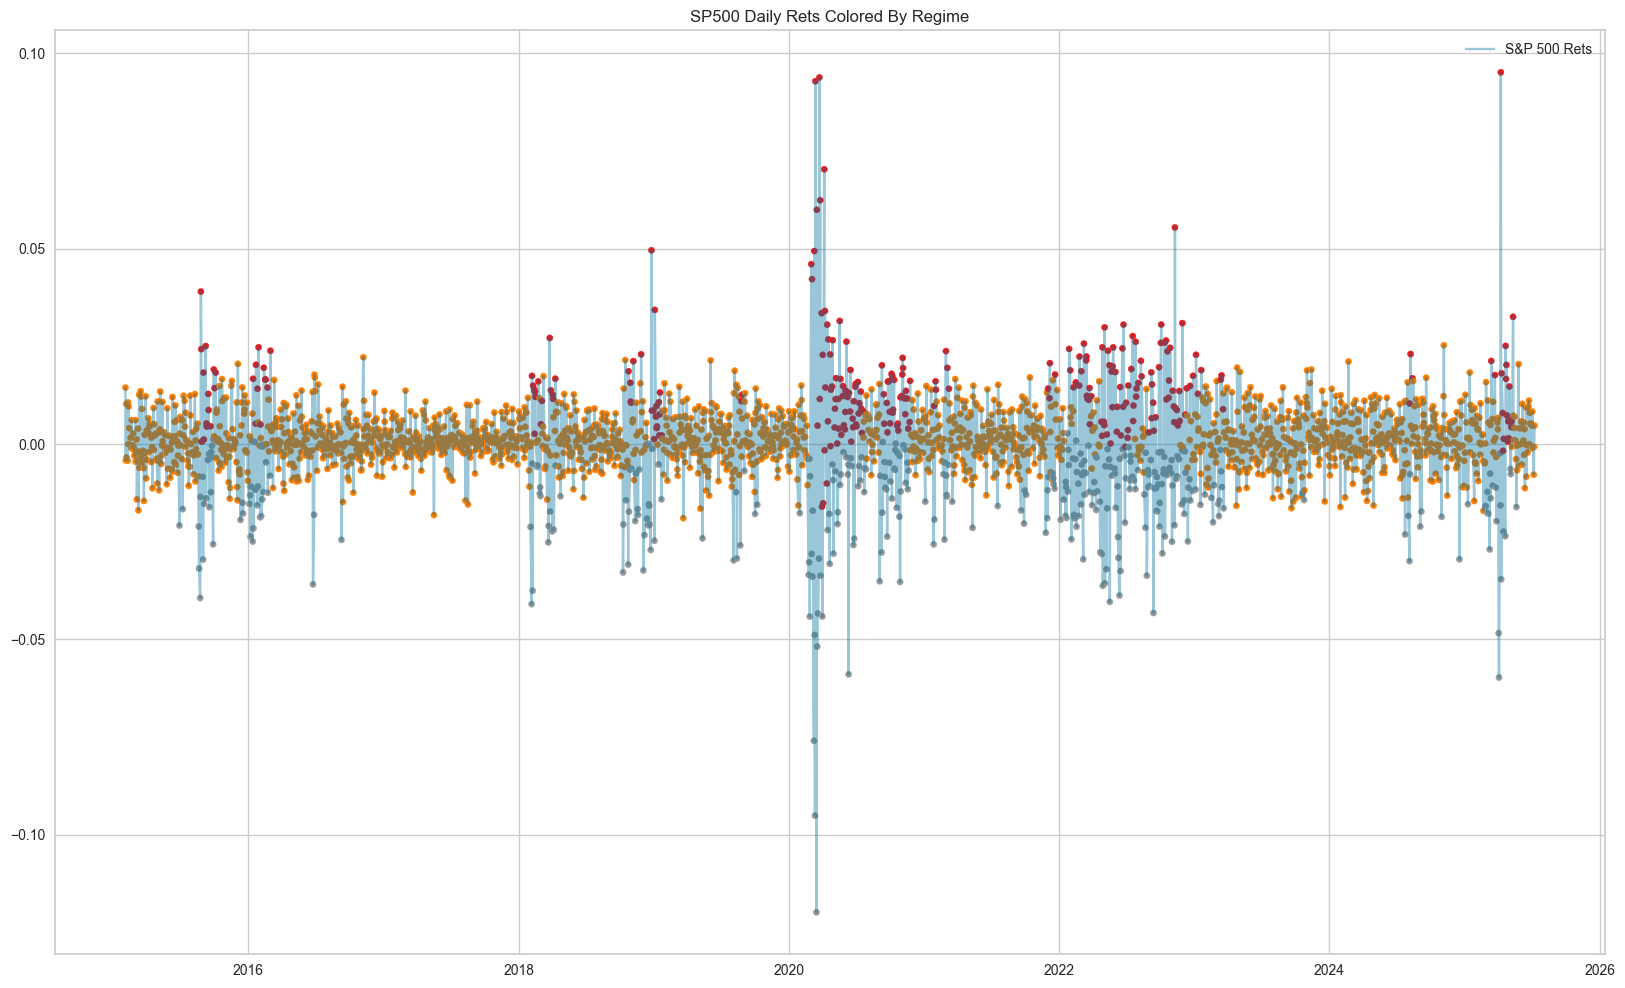

In [7]:
plt.figure(figsize=(20,12))
plt.plot(data['SP500_ret'], label='S&P 500 Rets', alpha=0.4)
plt.scatter(data.index, data['SP500_ret'], c=data['regime'], cmap='Set1', s=20)
plt.title('SP500 Daily Rets Colored By Regime')
plt.legend()
plt.show()

## Summary of Regime Statistics

In [8]:
regime_stats = data.groupby('regime').agg({
    'SP500_ret': ['mean', 'std'],
    'SP500_vol_21d': 'mean',
    '^VIX': 'mean'
}).rename(columns={
    'SP500_ret': 'Return',
    'SP500_vol_21d': 'Volatility (21d)',
    '^VIX': 'VIX Level'
})

# Flatten multi-index columns
regime_stats.columns = ['_'.join(col).strip() for col in regime_stats.columns.values]
regime_stats = regime_stats.reset_index()

# Rename columns for clarity
regime_stats.columns = ['Regime', 'Mean Return', 'Return Std Dev', 'Mean Volatility (21d)', 'Mean VIX Level']

regime_stats

,Regime,Mean Return,Return Std Dev,Mean Volatility (21d),Mean VIX Level
0,0,0.015196,0.013772,0.019154,27.632774
1,1,0.001375,0.006199,0.007256,15.435518
2,2,-0.015593,0.013137,0.014970,27.736184


In [17]:
data['regime'].value_counts()

regime
1    1990
2     359
0     274
Name: count, dtype: int64

We can classify the regimes by the following:
* Regime 0: positive return, high volatility, high VIX
* Regime 1: no return, low vol, low VIX
* Regime 2: negative return, high volatility, high VIX

Let's visualize the regimes in a radar plot

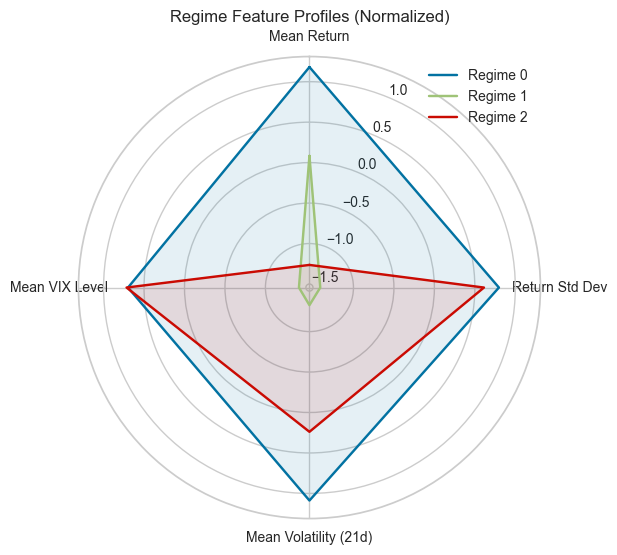

In [9]:
# Normalize for radar plot
features = ['Mean Return', 'Return Std Dev', 'Mean Volatility (21d)', 'Mean VIX Level']

scaler = StandardScaler()
scaled = scaler.fit_transform(regime_stats[features])

# Radar plot setup
labels = features
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the loop

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for i, row in enumerate(scaled):
    values = row.tolist() + row.tolist()[:1]
    ax.plot(angles, values, label=f'Regime {i}')
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Regime Feature Profiles (Normalized)")
plt.legend(loc='upper right')
plt.show()

Definitely feels like there are some differences between the three regimes, at least visually. Let's see if we can run some statistical analysis to check whether the returns are statistically different from one another between the different regimes.

## Statistical Analysis

#### t-Test of Means

In [10]:
# Get all unique regime values
regimes = data['regime'].unique()

# Loop over all pairs of regimes
for reg1, reg2 in combinations(regimes, 2):
    r1 = data[data['regime'] == reg1]['SP500_ret']
    r2 = data[data['regime'] == reg2]['SP500_ret']
    t_stat, p_val = ttest_ind(r1, r2, equal_var=False) # --> assume different var = Welch's t-test
    print(f"Regime {reg1} vs Regime {reg2} --> T-statistic: {t_stat:.2f}, P-value: {p_val:.4f}")

Regime 1 vs Regime 2 --> T-statistic: 24.00, P-value: 0.0000
Regime 1 vs Regime 0 --> T-statistic: -16.38, P-value: 0.0000
Regime 2 vs Regime 0 --> T-statistic: -28.43, P-value: 0.0000


Clearly, the returns are all significantly different. We can reject all nulls that state they are the same. This implies the KMeans algorithm is doing a good job detecting meaningfully different regimes (at least based on the returns feature).

#### Confidence Intervals

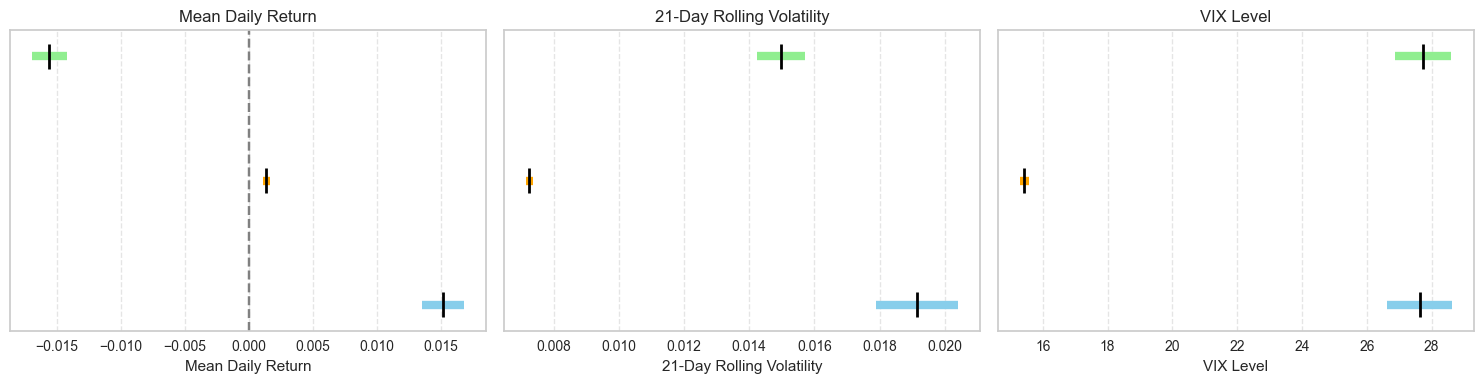

In [11]:
features = {
    'SP500_ret': 'Mean Daily Return',
    'SP500_vol_21d': '21-Day Rolling Volatility',
    '^VIX': 'VIX Level'
}

colors = ['skyblue', 'orange', 'lightgreen']
y_labels = ['Regime 0', 'Regime 1', 'Regime 2']
regimes = sorted(data['regime'].unique())

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for ax, (feature, xlabel) in zip(axes, features.items()):
    means = []
    errors = []

    for i in regimes:
        sample = data[data['regime'] == i][feature].dropna()
        m = np.mean(sample)
        se = stats.sem(sample)
        h = se * stats.t.ppf(0.975, len(sample) - 1)
        means.append(m)
        errors.append(h)

    y_positions = np.arange(len(means))

    for i, (mean, error, color) in enumerate(zip(means, errors, colors)):
        # Horizontal CI bar
        ax.hlines(y=y_positions[i], xmin=mean - error, xmax=mean + error, color=color, linewidth=6)
        # Short vertical mean line (half height)
        ax.vlines(x=mean, ymin=y_positions[i] - 0.1, ymax=y_positions[i] + 0.1, color='black', linewidth=2)

    ax.set_xlabel(xlabel)
    if 'Return' in xlabel:
        ax.axvline(0, color='gray', linestyle='--')
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.set_title(xlabel)

# Left-most plot gets y-axis labels
axes[0].set_yticks(y_positions)
axes[0].set_yticklabels(y_labels)

# Hide y-axis ticks for other plots
for ax in axes[1:]:
    ax.set_yticks([])

plt.tight_layout()
plt.show()



In the above chart, the colored bars represent the confidence interval and the small vertical black lines represent the mean. 

Observations:
* The mean daily return and 21-day rolling volatility exhibit zero overlapping confidence intervals between the regimes. This implies that the algo has done a good job at distinctly identifying the different regimes at each timestep.
* The VIX level, however, does show some overlap in the confidence intervals between Regime 0 and Regime 2. It's not necessarily a bad thing, as this might imply that this specific feature is not a strong separator between those two regimes.

## Evaluate KMeans Model

Let's evaluate the model with typical quantitative metrics: Silhouette score and WCSS

#### Silhouette Score

In [12]:
X_scaled = scaler.fit_transform(data[['SP500_ret', 'SP500_vol_21d', '^VIX']].dropna())
labels = data.loc[~data[['SP500_ret', 'SP500_vol_21d', '^VIX']].isna().any(axis=1), 'regime']

score = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.496


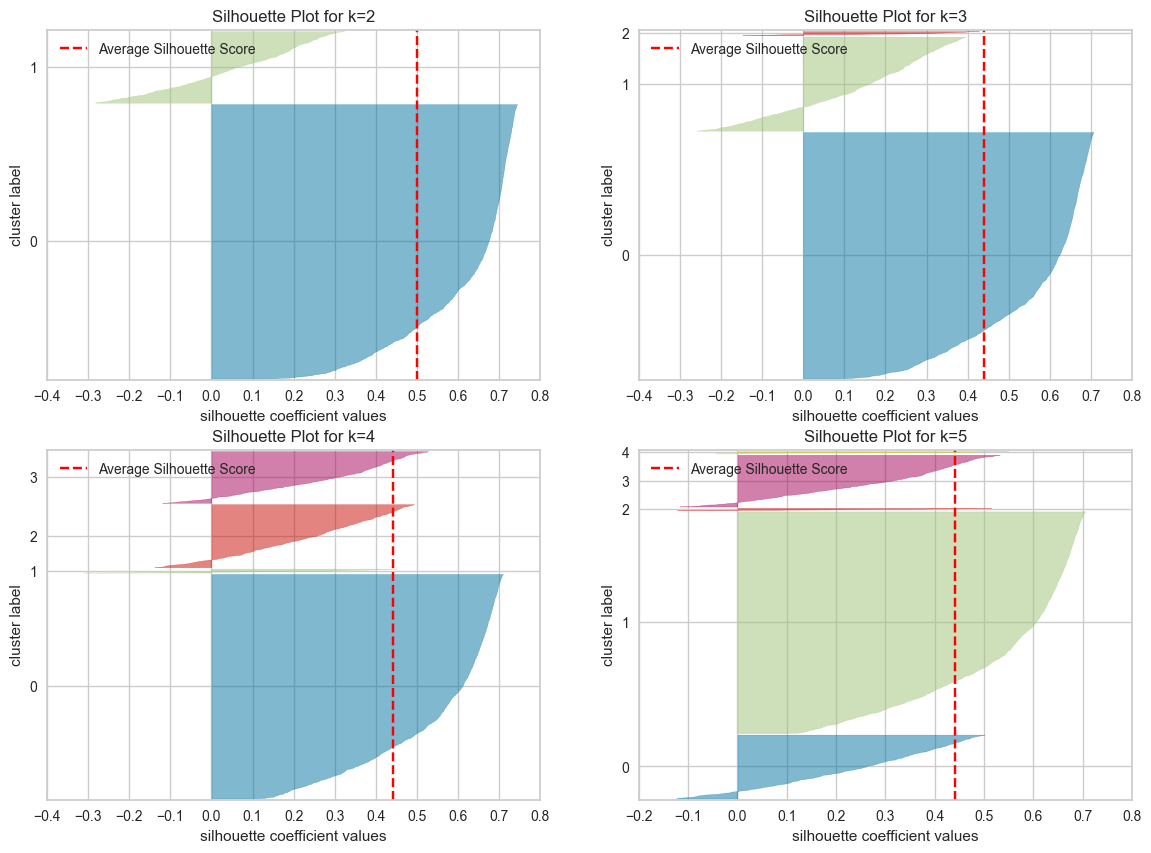

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

X = scaler.fit_transform(data[['SP500_ret', 'SP500_vol_21d', '^VIX']].dropna())

k_vals = [2, 3, 4, 5]

for ax, k in zip(axes.flatten(), k_vals):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
    visualizer.fit(X)
    visualizer.finalize()
    ax.set_title(f'Silhouette Plot for k={k}')

Let's start by specifically looking at k=3 clusters (our algo from the notebook so far):
* Regime 0 is large and has no negatives --> a good cluster
* Regime 1 is decently sized and has a negative peak --> iffy cluster
* Regime 2 is very small/thin and has a small negative peak as well --> likely a "bad" or weak cluster

I wouldn't say this model looks like a home run - there's some slight ambiguity, but overall this is some good structure and the model is easy to interpret. It's worth looking at k=2 and k=4.

k=2
* Regime 1 has decent size but still shows negative peaks
* Regime 0 is still large with no negatives
* This suggests there's not much benefit moving to k=2

k=4
* Regimes 0, 2, and 3 all look better than in k=3 - better sizing and smaller negatives
* Regime 1, however, is so tiny that it might likely be noise
* k=4 cluster separation is definitely and improvement over k=3
* However, added complexity without interpretability or economic clarity of 4 regimes is more difficult as compared to k=3. I'm not sure this is helpful either

Ultimately, we'll stick with k=3 as it provides a good balance between cluster quality and interpretability.

One thing to note as well: in general, the majority of returns will be positive over this time period as the market index will rise. It's no surprise then that Regime 0 (positive returns with high volatility) is easy to fit and has a good silhouette profile. Regime 2 for k=3, on the other hand, are negative returns and high volatility. This is much more unlikely, and so it too is not really a huge surprise that the silhouette visual for this regime is a tiny sliver.

#### Inertia (WCSS)

Elbow method to find the optimal k for number of clusters isn't super helpful here because in finance the domain knowledge and interpretability of clusters largely takes precedence. What would k=20 tell us?

Let's still look at it, but largely just as an exercise to visualize what this might look like in a stock market environment.

In [18]:
for i in range(2, 6):
    inertia = KMeans(n_clusters=i, random_state=42).fit(X_scaled).inertia_
    print(f"WCSS (Inertia) for {i} clusters: {inertia:.2f}")

WCSS (Inertia) for 2 clusters: 5292.60
WCSS (Inertia) for 3 clusters: 4229.84
WCSS (Inertia) for 4 clusters: 3039.61
WCSS (Inertia) for 5 clusters: 2696.51


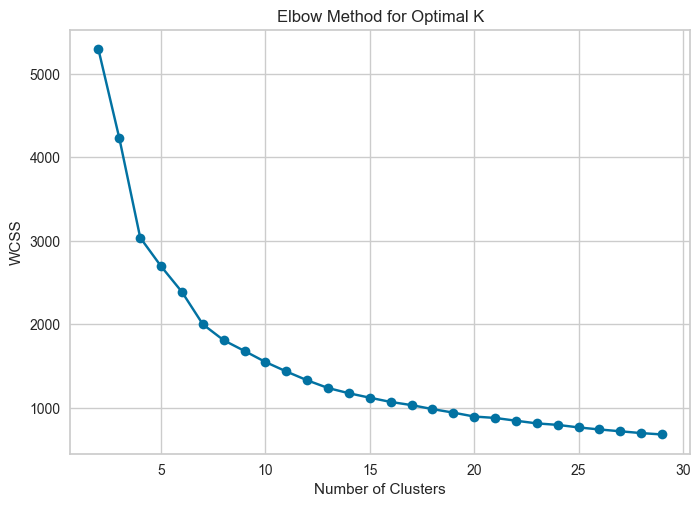

In [14]:
wcss = []
max_clusters = 30
for k in range(2, max_clusters):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, max_clusters), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()


Thinking ahead to being able to programmatically provide a "best" number of clusters to the end user, let's look at how we might do that...

## Progammatic k Clusters

In [19]:
def select_best_k(X, k_range=range(2, 6)):
    scores = []
    for k in k_range:
        model = KMeans(n_clusters=k, random_state=42).fit(X)
        labels = model.labels_
        score = silhouette_score(X, labels)
        scores.append((k, score))
    
    best_k, best_score = max(scores, key=lambda x: x[1])
    return best_k, scores

In [20]:
select_best_k(X_scaled)

(2,
 [(2, 0.5005194054017175),
  (3, 0.4964883514574492),
  (4, 0.4432350990256981),
  (5, 0.33575384844365475)])